In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Helper Functions
# TODO: convert to python script

def one_hot_encoder(str_list, df, target_col):
    df[str_list] = 0
    for cols in str_list:
        mask = df[target_col] == cols
        df.loc[mask,cols] = 1
        df[cols] = df[cols].astype('int32')
    return df

def check_month_year_mask(df,col_str):
    missing_mask = df[col_str[0]].isnull().values
    missing_freq_mask = df[col_str[1]].isnull().values

    if (missing_mask  == missing_freq_mask).all():
        return missing_mask
    else:
        return missing_mask, missing_freq_mask

def compute_duration(df,mask,col_str,freq):
    if freq == 'M':
        divisor = 12
    elif freq == 'W':
        divisor = 52

    [current_month,current_year,start_month,start_year] = [df[x].loc[mask].values for x in col_str]
    duration = (current_month-start_month)/divisor + (current_year - start_year)
    return np.maximum(duration,0)*divisor

#  Convert dtypes to int32
def converter_int32(df):
    for cols in df.columns:
        if df[cols].dtypes in ['int32','float32','int64','float64']:
            df[cols] = df[cols].astype('int32')
        else:
            df[cols] = df[cols].astype('str')
    return df

### I. INITIALIZE TRAIN DATA

In [3]:
df_store_info = pd.read_csv("../../data/raw/store.csv").drop_duplicates()
df_store_info.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [4]:
df_store_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [5]:
df_train_chunks = pd.read_csv("../../data/raw/train.csv", iterator=True, chunksize=1000)  # csv reading is done in chunks to process large data
df_train = pd.concat(df_train_chunks, ignore_index=True)
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,4,2015-04-30,6228,650,1,1,0,0
1,2,4,2015-04-30,6884,716,1,1,0,0
2,3,4,2015-04-30,9971,979,1,1,0,0
3,4,4,2015-04-30,16106,1854,1,1,0,0
4,5,4,2015-04-30,6598,729,1,1,0,0


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 914629 entries, 0 to 914628
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Store          914629 non-null  int64 
 1   DayOfWeek      914629 non-null  int64 
 2   Date           914629 non-null  object
 3   Sales          914629 non-null  int64 
 4   Customers      914629 non-null  int64 
 5   Open           914629 non-null  int64 
 6   Promo          914629 non-null  int64 
 7   StateHoliday   914629 non-null  object
 8   SchoolHoliday  914629 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 62.8+ MB


### II. PROCESS NULL DATA AND FEATURE EXTRACTION

In [7]:
# Remove Null Values on PromoInterval

df_store_info['PromoInterval'] = df_store_info['PromoInterval'].fillna('No_Promo')

In [8]:
promo_sched = df_store_info['PromoInterval'].drop_duplicates().to_list()
promo_sched

['No_Promo', 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec']

In [9]:
# Employ One Hot Encoding and drop PromoInterval column

df_store_info = one_hot_encoder(promo_sched, df_store_info, 'PromoInterval')
df_store_info[['PromoInterval'] + promo_sched].head()

,PromoInterval,No_Promo,"Jan,Apr,Jul,Oct","Feb,May,Aug,Nov","Mar,Jun,Sept,Dec"
0,No_Promo,1,0,0,0
1,"Jan,Apr,Jul,Oct",0,1,0,0
2,"Jan,Apr,Jul,Oct",0,1,0,0
3,No_Promo,1,0,0,0
4,No_Promo,1,0,0,0


In [10]:
# setting Tuple ID (Store, Date)

df_train['Id'] = list(zip(df_train['Store'].values, df_train['Date'].values))

In [11]:
# Merge train.csv and store.csv

df_merged = df_train.merge(df_store_info, on='Store', how='outer').set_index('Id',drop=True)
df_merged.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,No_Promo,"Jan,Apr,Jul,Oct","Feb,May,Aug,Nov","Mar,Jun,Sept,Dec"
Id,,,,,,,,,,,,,,,,,,,,,
"(1, 2015-04-30)",1,4,2015-04-30,6228,650,1,1,0,0,c,...,9.0,2008.0,0,NaN,NaN,No_Promo,1,0,0,0
"(1, 2015-04-29)",1,3,2015-04-29,5775,579,1,1,0,0,c,...,9.0,2008.0,0,NaN,NaN,No_Promo,1,0,0,0
"(1, 2015-04-28)",1,2,2015-04-28,5199,552,1,1,0,0,c,...,9.0,2008.0,0,NaN,NaN,No_Promo,1,0,0,0
"(1, 2015-04-27)",1,1,2015-04-27,5575,574,1,1,0,0,c,...,9.0,2008.0,0,NaN,NaN,No_Promo,1,0,0,0
"(1, 2015-04-26)",1,7,2015-04-26,0,0,0,0,0,0,c,...,9.0,2008.0,0,NaN,NaN,No_Promo,1,0,0,0


In [12]:
# Drop duplicates if any

df_merged = df_merged.drop_duplicates()
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 914629 entries, (1, '2015-04-30') to (1115, '2013-01-01')
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      914629 non-null  int64  
 1   DayOfWeek                  914629 non-null  int64  
 2   Date                       914629 non-null  object 
 3   Sales                      914629 non-null  int64  
 4   Customers                  914629 non-null  int64  
 5   Open                       914629 non-null  int64  
 6   Promo                      914629 non-null  int64  
 7   StateHoliday               914629 non-null  object 
 8   SchoolHoliday              914629 non-null  int64  
 9   StoreType                  914629 non-null  object 
 10  Assortment                 914629 non-null  object 
 11  CompetitionDistance        912263 non-null  float64
 12  CompetitionOpenSinceMonth  623849 non-null  float64
 13  Comp

In [13]:
# Convert Date to Week Month Year
# NOTE: dtype of float or int64 is converted to int32 to reduce memory use

df_merged['Date'] = pd.DatetimeIndex(df_merged['Date'])  # Convert to period.
df_merged['Year'] = df_merged['Date'].apply(lambda x: x.year)
df_merged['Month'] = df_merged['Date'].apply(lambda x: x.month)
df_merged['Week'] = df_merged['Date'].apply(lambda x: x.week)
df_merged.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'No_Promo', 'Jan,Apr,Jul,Oct',
       'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec', 'Year', 'Month', 'Week'],
      dtype='object')

In [14]:
# Determine duration since Competition is Open.
# Current date(month, year) - Competition Open Date (month, year)

date_str = ['Month','Year']
com_open_str = ['CompetitionOpenSinceMonth','CompetitionOpenSinceYear']
compe_mask = ~check_month_year_mask(df_merged,com_open_str)

compe_inputs = (df_merged, compe_mask, date_str + com_open_str, 'M')
df_merged.loc[compe_mask,'CompetitionOpenSinceDuration'] = compute_duration(*compe_inputs).astype('int32')

In [15]:
# Determine duration since Promo2 is started.
# Current date(week, year) - Competition Open Date (week, year)

week_str = ['Week','Year']
promo2_str = ['Promo2SinceWeek','Promo2SinceYear']
promo_mask = ~check_month_year_mask(df_merged,promo2_str)

promo_inputs = (df_merged, promo_mask, week_str + promo2_str, 'W')
df_merged.loc[promo_mask,'Promo2SinceDuration'] = compute_duration(*promo_inputs).astype('int32')

In [16]:
# Date duration for rows with no Competition opening and Promo2 opening is zero.

fill_na_str = ['CompetitionOpenSinceDuration', 'Promo2SinceDuration']
df_merged[fill_na_str] = df_merged[fill_na_str].fillna(0.0)

In [17]:
# Competition distance for accounts with no competition is zero

df_merged['CompetitionDistance'] = df_merged['CompetitionDistance'].fillna(0.0)

In [18]:
# Drop columns where new features were extracted from

columns_drop = ['Date', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
df_merged = df_merged.drop(columns_drop,axis=1)

In [19]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 914629 entries, (1, '2015-04-30') to (1115, '2013-01-01')
Data columns (total 21 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Store                         914629 non-null  int64  
 1   DayOfWeek                     914629 non-null  int64  
 2   Sales                         914629 non-null  int64  
 3   Customers                     914629 non-null  int64  
 4   Open                          914629 non-null  int64  
 5   Promo                         914629 non-null  int64  
 6   StateHoliday                  914629 non-null  object 
 7   SchoolHoliday                 914629 non-null  int64  
 8   StoreType                     914629 non-null  object 
 9   Assortment                    914629 non-null  object 
 10  CompetitionDistance           914629 non-null  float64
 11  Promo2                        914629 non-null  int64  
 12  No_Promo           

### III. ONE HOT ENCODING FOR NOMINAL CATEGORICAL DATA

In [20]:
df_input = df_merged.copy()

In [21]:
# One Hot Encode State Holidays
hol_keys = ['0','a','b','c']
hol_vals = ['no_holiday','public_holiday','easter_holiday','christmas']
hol_list = dict(zip(hol_keys, hol_vals))

In [22]:
df_input = one_hot_encoder(hol_keys, df_input, 'StateHoliday')
df_input = df_input.rename(hol_list, axis=1).drop('StateHoliday', axis=1)
df_input[hol_vals].head()

,no_holiday,public_holiday,easter_holiday,christmas
Id,,,,
"(1, 2015-04-30)",0,0,0,0
"(1, 2015-04-29)",0,0,0,0
"(1, 2015-04-28)",0,0,0,0
"(1, 2015-04-27)",0,0,0,0
"(1, 2015-04-26)",0,0,0,0


In [23]:
# One Hot Encode Assortment

assort_keys = ['a','b','c']
assort_vals = ['basic','extra','extended']
assort_list = dict(zip(assort_keys, assort_vals))

In [24]:
df_input = one_hot_encoder(assort_keys, df_input, 'Assortment')
df_input = df_input.rename(assort_list, axis=1).drop('Assortment', axis=1)
df_input[assort_vals].head()

,basic,extra,extended
Id,,,
"(1, 2015-04-30)",1,0,0
"(1, 2015-04-29)",1,0,0
"(1, 2015-04-28)",1,0,0
"(1, 2015-04-27)",1,0,0
"(1, 2015-04-26)",1,0,0


In [25]:
# One Hot Encode StoreType

storetype_keys = ['a','b','c','d']
storetype_vals = ['store_type_a', 'store_type_b', 'store_type_c', 'store_type_d']
storetype_list = dict(zip(storetype_keys, storetype_vals))

In [26]:
df_input = one_hot_encoder(storetype_keys, df_input, 'StoreType')
df_input = df_input.rename(storetype_list, axis=1).drop('StoreType', axis=1)
df_input[storetype_vals].head()

,store_type_a,store_type_b,store_type_c,store_type_d
Id,,,,
"(1, 2015-04-30)",0,0,1,0
"(1, 2015-04-29)",0,0,1,0
"(1, 2015-04-28)",0,0,1,0
"(1, 2015-04-27)",0,0,1,0
"(1, 2015-04-26)",0,0,1,0


In [27]:
# One Hot Encode Days of the week 
# Commented out due to being an ordinal categorical data

week_keys = ['mon','tue','wed','thu','fri','sat','sun']
week_vals = list(range(1,8))
week_list = dict(zip(week_vals, week_keys))

In [28]:
df_input = one_hot_encoder(week_vals, df_input, 'DayOfWeek')
df_input = df_input.rename(week_list, axis=1).drop('DayOfWeek', axis=1)

In [29]:
df_input = converter_int32(df_input)
df_input.info()

<class 'pandas.core.frame.DataFrame'>
Index: 914629 entries, (1, '2015-04-30') to (1115, '2013-01-01')
Data columns (total 35 columns):
 #   Column                        Non-Null Count   Dtype
---  ------                        --------------   -----
 0   Store                         914629 non-null  int32
 1   Sales                         914629 non-null  int32
 2   Customers                     914629 non-null  int32
 3   Open                          914629 non-null  int32
 4   Promo                         914629 non-null  int32
 5   SchoolHoliday                 914629 non-null  int32
 6   CompetitionDistance           914629 non-null  int32
 7   Promo2                        914629 non-null  int32
 8   No_Promo                      914629 non-null  int32
 9   Jan,Apr,Jul,Oct               914629 non-null  int32
 10  Feb,May,Aug,Nov               914629 non-null  int32
 11  Mar,Jun,Sept,Dec              914629 non-null  int32
 12  Year                          914629 non-null  

In [30]:
# One Hot Encode Months
# Commented out due to being an ordinal categorical data

month_vals = list(range(1,13))
month_keys = ['month_' +str(x) for x in month_vals]
month_list = dict(zip(month_vals, month_keys))

In [31]:
df_input = one_hot_encoder(month_vals, df_input, 'Month')
df_input = df_input.rename(month_list, axis=1).drop('Month', axis=1)

In [32]:
df_input = converter_int32(df_input)
df_input.info()

<class 'pandas.core.frame.DataFrame'>
Index: 914629 entries, (1, '2015-04-30') to (1115, '2013-01-01')
Data columns (total 46 columns):
 #   Column                        Non-Null Count   Dtype
---  ------                        --------------   -----
 0   Store                         914629 non-null  int32
 1   Sales                         914629 non-null  int32
 2   Customers                     914629 non-null  int32
 3   Open                          914629 non-null  int32
 4   Promo                         914629 non-null  int32
 5   SchoolHoliday                 914629 non-null  int32
 6   CompetitionDistance           914629 non-null  int32
 7   Promo2                        914629 non-null  int32
 8   No_Promo                      914629 non-null  int32
 9   Jan,Apr,Jul,Oct               914629 non-null  int32
 10  Feb,May,Aug,Nov               914629 non-null  int32
 11  Mar,Jun,Sept,Dec              914629 non-null  int32
 12  Year                          914629 non-null  

In [33]:
# One Hot Encode Weeks 
# Commented out due to being an ordinal categorical data

week_vals = np.sort(df_input['Week'].unique())
week_keys = ['week_' +str(x) for x in week_vals]
week_list = dict(zip(week_vals, week_keys))

In [34]:
df_input = one_hot_encoder(week_vals, df_input, 'Week')
df_input = df_input.rename(week_list, axis=1).drop('Week', axis=1)

In [35]:
df_input = converter_int32(df_input)
df_input.info()

<class 'pandas.core.frame.DataFrame'>
Index: 914629 entries, (1, '2015-04-30') to (1115, '2013-01-01')
Data columns (total 97 columns):
 #   Column                        Non-Null Count   Dtype
---  ------                        --------------   -----
 0   Store                         914629 non-null  int32
 1   Sales                         914629 non-null  int32
 2   Customers                     914629 non-null  int32
 3   Open                          914629 non-null  int32
 4   Promo                         914629 non-null  int32
 5   SchoolHoliday                 914629 non-null  int32
 6   CompetitionDistance           914629 non-null  int32
 7   Promo2                        914629 non-null  int32
 8   No_Promo                      914629 non-null  int32
 9   Jan,Apr,Jul,Oct               914629 non-null  int32
 10  Feb,May,Aug,Nov               914629 non-null  int32
 11  Mar,Jun,Sept,Dec              914629 non-null  int32
 12  Year                          914629 non-null  

In [36]:
# Save processed data to csv

df_input_main = df_input.copy()
# df_input_main.to_csv('processed_data.csv')

### MISCELLANEOUS: EXPLORATORY DATA ANALYSIS OF NUMERICAL VALUES AND ORDINAL VALUES

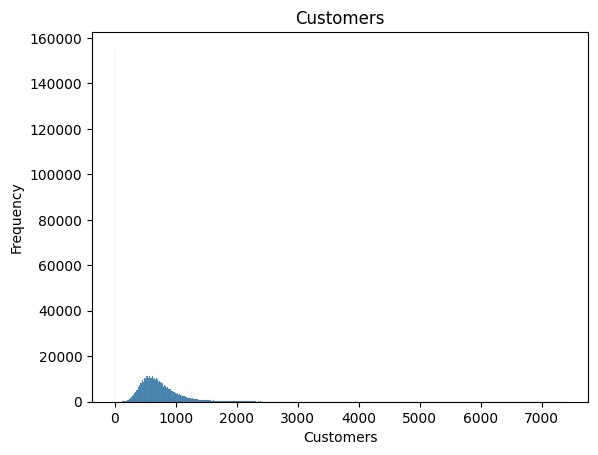

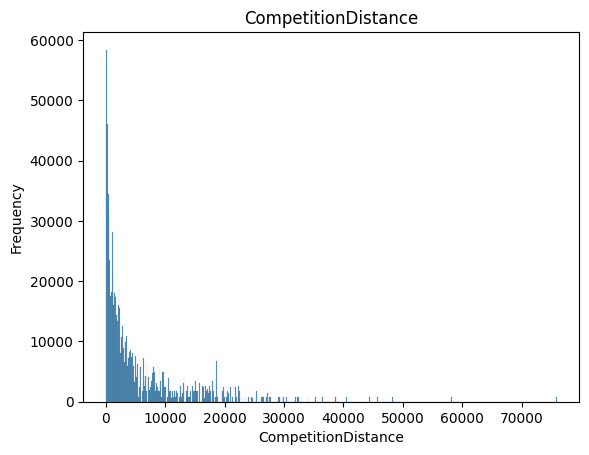

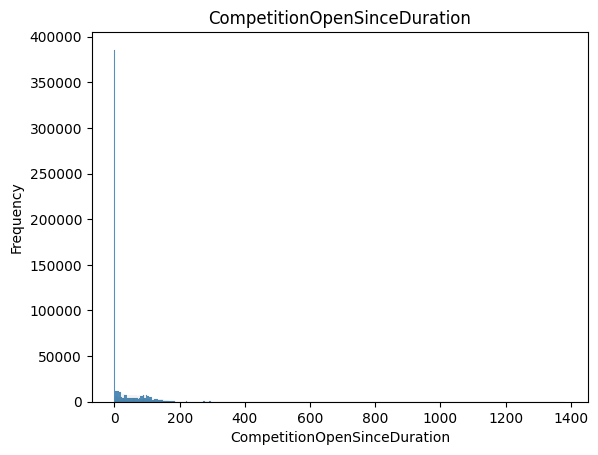

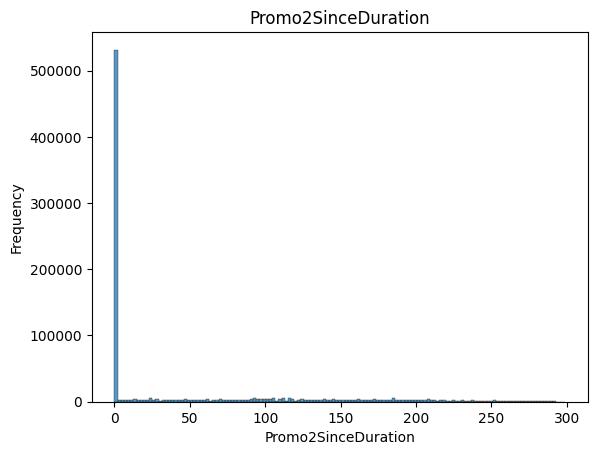

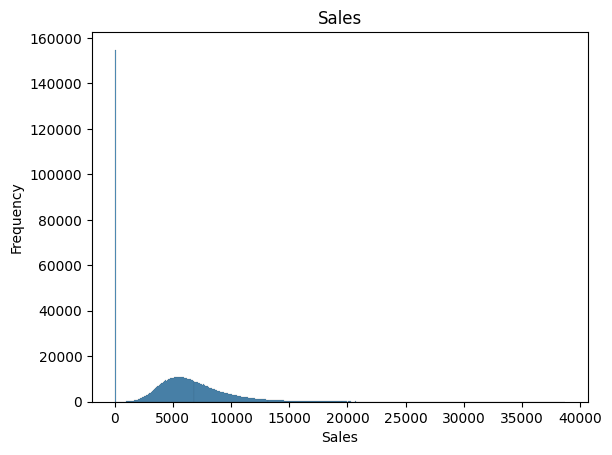

In [37]:
# Histogram of numerical data

num_str = ['Customers', 'CompetitionDistance', 'CompetitionOpenSinceDuration', 'Promo2SinceDuration', 'Sales']
for col in num_str:
    sns.histplot(df_input[col])
    plt.title(col)
    plt.ylabel('Frequency')
    plt.show()


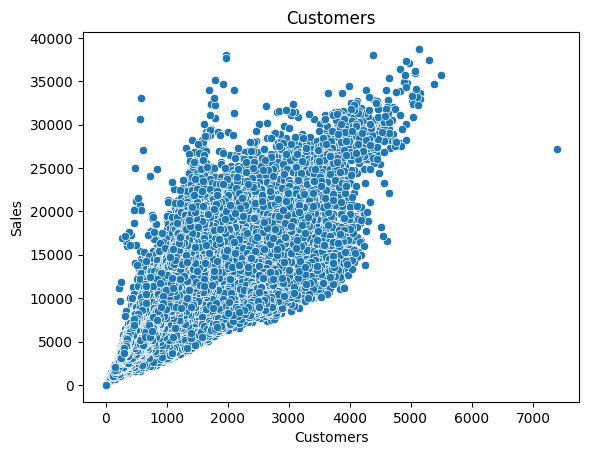

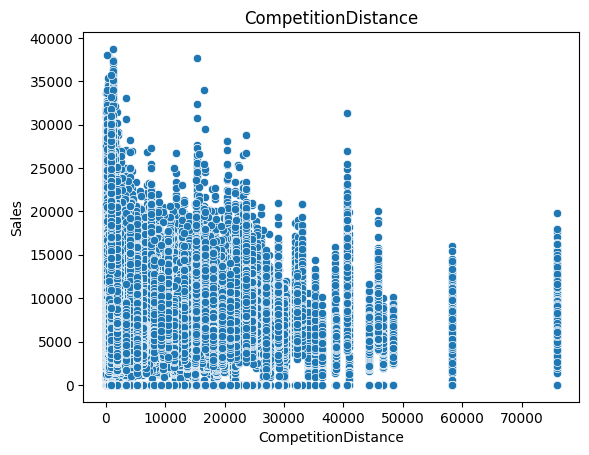

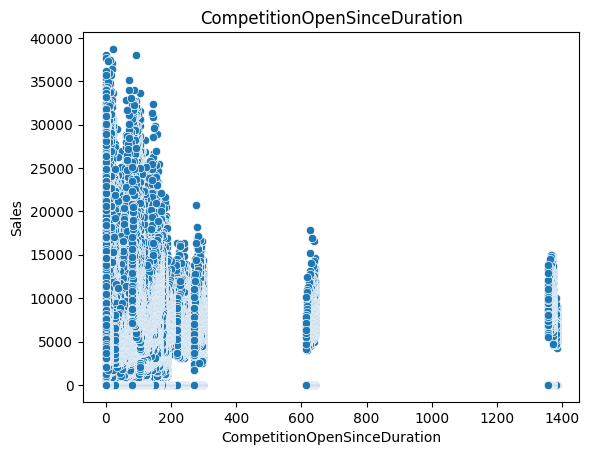

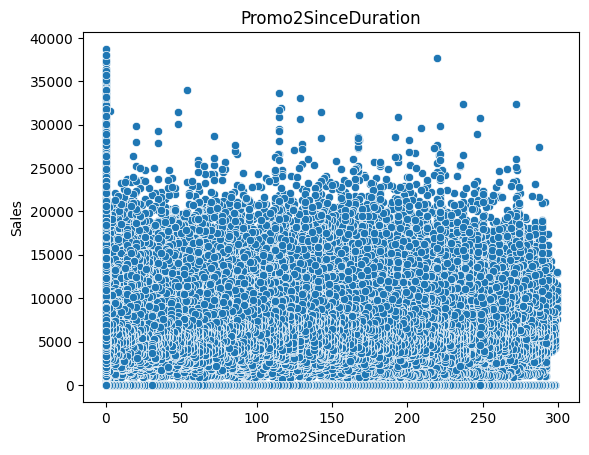

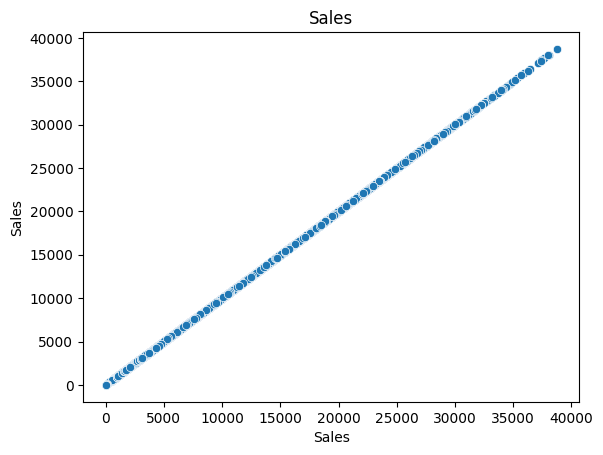

In [38]:
# visualize the relationship between the numerical features and the response using scatterplots
for col in num_str:
    sns.scatterplot(data=df_input, x=col, y='Sales')
    plt.title(col)
    plt.show()

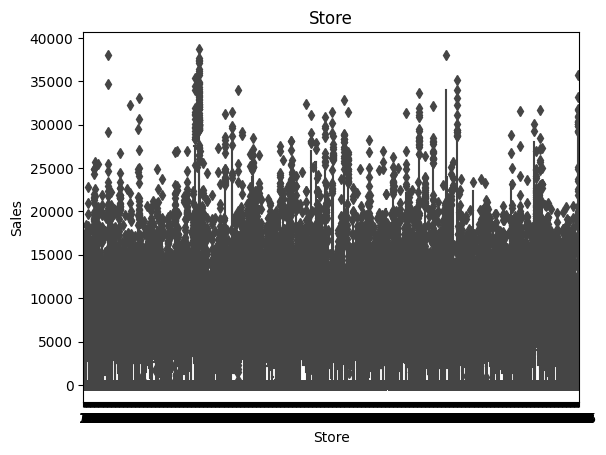

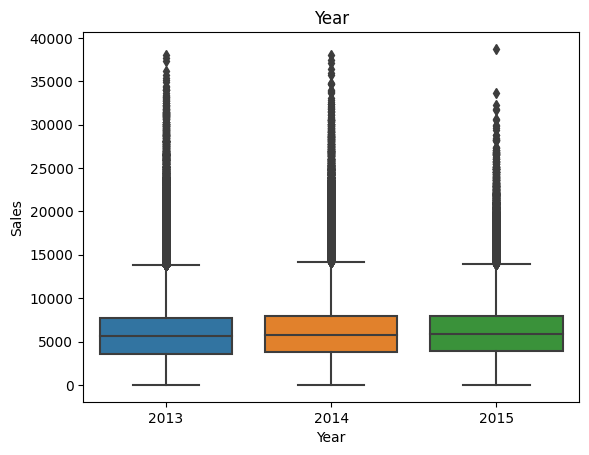

In [39]:
# visualize the relationship between the ordinal features and the response using scatterplots
ord_str = ['Store', 'Year']

for col in ord_str:
    sns.boxplot(data=df_input, x=col, y='Sales')
    plt.title(col)
    plt.show()